## Cookie Cats A/B testing

This dataset and introduction description have been found online

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It is a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Shape: (90189, 5)

Count: userid            90189
version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

Duplicated: 0

Null: userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


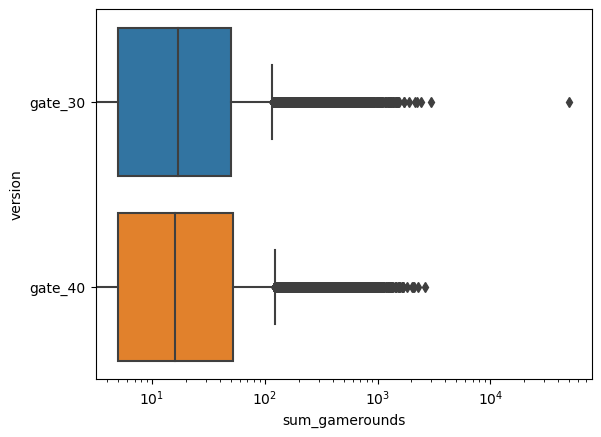

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cats = pd.read_csv("cookie_cats.csv")

#view info on data
print(cats.head())
print("\nShape:", cats.shape)

#see if any duplicates or na
print("\nCount:", cats.count())
print("\nDuplicated:", cats["userid"].duplicated().sum())
print("\nNull:", cats.isnull().sum())

#see rough distribution for of gamerounds per gate level
cats.groupby("version")["userid"].nunique()
ax = sns.boxplot(data=cats, x="sum_gamerounds", y="version", orient="h")
ax.set_xscale('log')
plt.show()

There is one player who played far too many games, this is likely to be a mistake in the data.  Some players also didn't play at all, so remove them from the data

In [2]:
cats.drop(cats[(cats["sum_gamerounds"]>10000) | (cats["sum_gamerounds"]==0)].index, inplace=True)
cats[cats["sum_gamerounds"] == 0].groupby("version")["userid"].nunique()

Series([], Name: userid, dtype: int64)

Plot a few simple graphs to visually see how the different gates affect retention rate

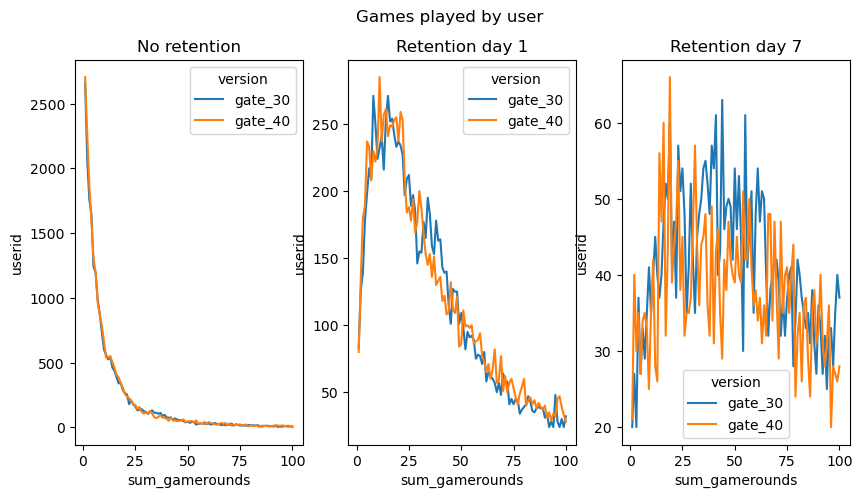

In [3]:
#view how many games people played verses retention rate
fig, ax = plt.subplots(1,3,sharey=False)
fig.set_size_inches((10,5))
fig.suptitle("Games played by user")

tempcats = cats[cats["retention_1"]==False].groupby(["version","sum_gamerounds"],as_index=False)\
    [["userid"]].count().sort_values("sum_gamerounds")[0:200]
ax[0] = plt.subplot(1,3,1)
ax[0] = sns.lineplot(data=tempcats,x="sum_gamerounds",y="userid",hue="version")
ax[0].set_title("No retention")

tempcats = cats[(cats["retention_1"]==True) & (cats["retention_7"]==False)].\
    groupby(["version","sum_gamerounds"],as_index=False)[["userid"]].count().\
        sort_values("sum_gamerounds")[0:200]
ax[1] = plt.subplot(1,3,2)
ax[1] = sns.lineplot(data=tempcats,x="sum_gamerounds",y="userid",hue="version")
ax[1].set_title("Retention day 1")

tempcats = cats[cats["retention_7"]==True].groupby(["version","sum_gamerounds"],as_index=False)\
    [["userid"]].count().sort_values("sum_gamerounds")[0:200]
ax[2] = plt.subplot(1,3,3)
ax[2] = sns.lineplot(data=tempcats,x="sum_gamerounds",y="userid",hue="version")
ax[2].set_title("Retention day 7")

plt.show()

Although it looks like gate 30 has slightly better retention rate it isn't clear from the graphs

In [4]:
print(cats[cats["retention_7"]==True].groupby("retention_1").count())


#view retention rate
print("\n", cats.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean",\
                             "sum_gamerounds":"mean"}))

             userid  version  sum_gamerounds  retention_7
retention_1                                              
False          3574     3574            3574         3574
True          13177    13177           13177        13177

          userid  retention_1  retention_7  sum_gamerounds
version                                                  
gate_30   42762     0.467541     0.198424       53.667766
gate_40   43432     0.462171     0.190321       53.728357


It can be seen that 3500 people came back on day 7 but not day 1, this highlights that the retention means the user came back on this specific day and not after this day, i.e. if a user came back on day 2-6, and 8-20 this would not count as a retained user.  Unfortunately it is not possible to modify the data

Next a bootstrap distribution is created in order to get the sample distribution

In [5]:
ret1_boot = []
ret7_boot = []
for i in range(500):
    ret1_boot.append(cats.sample(frac=1, replace=True).groupby('version')['retention_1'].mean())
    ret7_boot.append(cats.sample(frac=1, replace=True).groupby('version')['retention_7'].mean())
    

ret1_boot = pd.DataFrame(ret1_boot)
ret7_boot = pd.DataFrame(ret7_boot)

Plot the bootstrap means to easily visualise retention rates

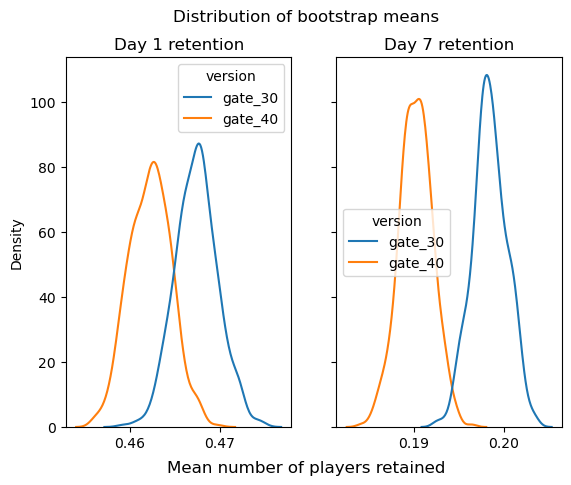

In [6]:
fig, ax = plt.subplots(1,2,sharey=True)
fig.suptitle("Distribution of bootstrap means")
fig.supxlabel("Mean number of players retained")
ax[0] = plt.subplot(1,2,1)
ax[0] = sns.kdeplot(data=ret1_boot)
ax[0].set_title("Day 1 retention")
ax[0] = plt.subplot(1,2,2)
ax[1] = sns.kdeplot(data=ret7_boot)
ax[1].set_title("Day 7 retention")

plt.show()

State our hypothesis and confidence level, then run a chi squared test to see if there is a link between the two retention rates

In [7]:
print("H0: There is no difference between gate 30 and gate 40")
print("H1: There is a difference between gate 30 and gate 40")
print("Test to a 95% confidence level, i.e. α = 0.05")


from scipy.stats import chi2_contingency
print("\nUsing Chi2:")
_,p,_,_ =  chi2_contingency(pd.crosstab(index=cats["version"], columns=cats["retention_1"]))
print(f"1 day retention p value is: {p:.3f}")
_,p,_,_ =  chi2_contingency(pd.crosstab(index=cats["version"], columns=cats["retention_7"]))
print(f"7 day retention p value is: {p:.3f}")

H0: There is no difference between gate 30 and gate 40
H1: There is a difference between gate 30 and gate 40
Test to a 95% confidence level, i.e. α = 0.05

Using Chi2:
1 day retention p value is: 0.116
7 day retention p value is: 0.003


At 1 day 0.116 > 0.05 so we do not reject the null hypothesis, telling us that there isn't a statistical difference between the gate positions

At 7 days 0.003 < 0.05 so we reject the null hypothesis in favour of the alternative hypothesis

Therefore overall there is a statistic difference in having the gate at level 30 and it should be kept at this level for improved retention